In [1]:
%load_ext autotime

In [2]:
import os
from glob import glob

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('bmh')

from tqdm import tqdm_notebook

from piaa.utils import pipeline
from piaa.utils.postgres import get_cursor
from piaa.utils import helpers
from pocs.utils.images import fits as fits_utils
from pocs.utils.images import crop_data

from piaa.utils.postgres import get_cursor
tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

time: 1.9 s


In [3]:
fields_dir = os.path.join(os.environ['PANDIR'], 'images', 'fields')

time: 719 µs


In [4]:
base_dir = os.path.join(fields_dir, 'PAN001/Hd189733/14d3bd/20180913T085704')
base_dir = os.path.join(fields_dir, 'PAN001/Hd189733/ee04d1/20180913T085704')
# base_dir = os.path.join(fields_dir, 'PAN012/Hd189733/358d0f/20180822T035809')
# base_dir = os.path.join(fields_dir, 'PAN001/Wasp50/ee04d1/20181215T050712')

base_dir

'/var/panoptes/images/fields/PAN001/Hd189733/ee04d1/20180913T085704'

time: 5.73 ms


In [5]:
# Get all the files that start with a time stamp (skip pointing files)
fits_files = sorted(glob(
    os.path.join(base_dir, '*2018*.fits')
), )
print("Found {} FITS files".format(len(fits_files)))

Found 100 FITS files
time: 2.36 ms


## Lookup point sources

Looking up the point sources invovles two steps, extracting detected sources from the image and matching those with a catalog.

> Note: This assumes the images have already been downloaded and plate-solved.  
> _todo(wtgee) add a link to a notebook that does that_

**Source Detection** For source extraction there are three methods available but the default is to use the well-known [`sextractor`](https://www.astromatic.net/software/sextractor) to  automatically detect sources according to certain configurable parameters. The [PIAA sextractor config](https://raw.githubusercontent.com/panoptes/PIAA/develop/resources/conf_files/sextractor/panoptes.sex) sets a photometric aperture of 6 pixels ($6 \times 10.3'' \approx 80''$) and a detection threshold of 1.5 sigmas. Further filtering of flags and basic SNR is done below.

**Catalog Matching** PANOPTES hosts a copy of the TESS Input Catalog (v6) against which the detected sources are matched. The detection uses the peak pixel value as reported by `sextractor` compared against the TICv6 using standard [astropy catalog matching](http://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs) techniques. Reported catalog separation is neglible, especially regarding the creationg of the stamps for the RGB pixel pattern (see below).

In [6]:
# Lookup the point sources
point_sources = pipeline.lookup_point_sources(
    fits_files[0], 
    force_new=True,
    cursor=tess_cursor,
)

# Display example
display(point_sources.head())
print(f'Sources extracted: {len(point_sources)}')

,ra,dec,x,y,x_image,y_image,background,flux_best,fluxerr_best,mag_best,...,flux_aper,fluxerr_aper,mag_aper,magerr_aper,flux_max,fwhm_image,flags,tmag,vmag,catalog_sep_arcsec
picid,,,,,,,,,,,,,,,,,,,,,
10676064,297.731379,29.103738,5145,697,5145.9980,696.8262,2066.387,1299.831,87.90568,17.2153,...,1080.9920,58.69989,17.4154,0.0590,129.53530,6.02,0,10.923,11.343,21.322441
10676191,297.815910,29.100670,5144,723,5144.5557,722.8771,2067.073,1988.160,109.77960,16.7539,...,1386.7400,60.53900,17.1450,0.0474,146.77000,6.02,0,11.839,13.054,11.768358
10676309,297.768533,29.078722,5138,708,5136.9551,708.2170,2066.429,1122.076,115.78780,17.3749,...,710.7996,56.52448,17.8706,0.0864,82.42879,5.69,0,11.890,12.145,20.246949
10676410,297.741659,29.068417,5132,700,5133.4087,699.9042,2066.094,1314.310,108.60750,17.2033,...,929.1666,57.76443,17.5798,0.0675,122.75010,5.36,0,11.119,11.911,17.540261
10763858,297.855030,29.044928,5126,734,5124.6025,734.8061,2068.656,1911.370,215.63370,16.7966,...,517.0848,55.33541,18.2161,0.1162,65.04959,10.91,0,11.895,12.500,17.836088


Sources extracted: 44814
time: 17.4 s


#### Lookup all files

Perform the same thing again but for all files. The resulting source catalog created from `sextractor` is saved for each image and reused in subsequent runs unless `force_new=True`.

Extract the observation time, the exposure time, and the airmass from the FITS headers.

The image observation time currently comes from the image file name, which is generated by the computer running the unit and is given in UTC. This is mainly due to a problem with the `DATE-OBS` header in the FITS files for POCS versions <0.6.2.

In [7]:
source_filename = os.path.join(base_dir, f'point-sources-detected.csv')

observation_sources = pipeline.lookup_sources_for_observation(
    fits_files=fits_files, 
    filename=source_filename, 
    cursor=tess_cursor, 
    force_new=True,
)

100%|██████████| 100/100 [32:22<00:00, 23.55s/it]


time: 35min 25s


In [8]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 100 Sources: 78754
time: 495 ms


## Filter detected sources

The above sequence does basic source filtering via `sextractor` along with what can be matched in the TESS catalog. Below are a number of different ways to filter the frames and/or sources based on image quality, number of detections, etc.

The filtering for the `PAN012` HD189733 data set involves the steps below. At the bottom of the notebook are optional filter methods.

#### Image filtering

We can do some quick checks on the overall image sequence. here we look at the mean background as detected by `sextractor`. It's a rough metric but we can clearly see some frames where the background levels spike, indicating clouds in the region.

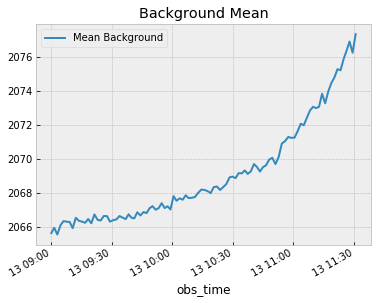

time: 1.96 s


In [9]:
plt.figure(figsize=(6, 4.5))
observation_sources.groupby('obs_time').background.mean().plot(label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

#### Filter frames by number of detected sources

Here we remove frames where the total number of detected frames is outside of two standard deviations of the mean number of detected sources.

Usually this is due to clouds passing over, which causes the number of detected sources to drop dramatically across the entire frame.

We could have a smarter method of filtering these frames, e.g. by examining the FWHM of the stars.

In [10]:
num_sources = observation_sources.groupby('obs_time').count().file
min_sources = int(num_sources.mean() - (2 * num_sources.std()))
print(f'Frames should have at least {min_sources} sources')

Frames should have at least 38626 sources
time: 610 ms


In [11]:
observation_sources.groupby('obs_time').describe().head()

ra                                                \
                       count        mean       std         min         25%   
obs_time                                                                     
2018-09-13 09:00:11  44814.0  301.098553  2.990756  295.678560  298.481650   
2018-09-13 09:01:38  44743.0  301.102858  2.988263  295.678991  298.490657   
2018-09-13 09:03:10  42113.0  301.100710  2.986259  295.660886  298.495092   
2018-09-13 09:04:44  44625.0  301.100794  2.987162  295.659918  298.483367   
2018-09-13 09:06:16  42884.0  301.095846  2.986646  295.659555  298.485969   

                                                             dec             \
                            50%         75%         max    count       mean   
obs_time                                                                      
2018-09-13 09:00:11  301.101906  303.709527  306.545850  44814.0  21.234164   
2018-09-13 09:01:38  301.106728  303.713484  306.545209  44743.0  21.219291   
2018-09-13 09:03:10  301.113124  303.701631  306.523456  42113.0  21.257553   
2018-09-13 09:04:44  301.112318  303.708007  306.528096  44625.0  21.226086   
2018-09-13 09:06:16  301.107359  303.705595  306.525421  42884.0  21.244554   

                         ...        airmass              picid                \
                         ...            75%       max    count          mean   
obs_time                 ...                                                   
2018-09-13 09:00:11      ...       1.147736  1.147736  44814.0  2.894145e+08   
2018-09-13 09:01:38      ...       1.151562  1.151562  44743.0  2.890158e+08   
2018-09-13 09:03:10      ...       1.155691  1.155691  42113.0  2.891467e+08   
2018-09-13 09:04:44      ...       1.159928  1.159928  44625.0  2.886771e+08   
2018-09-13 09:06:16      ...       1.164181  1.164181  42884.0  2.889353e+08   

                                                                         \
                              std         min          25%          50%   
obs_time                                                                  
2018-09-13 09:00:11  1.222296e+08  10676064.0  244384121.5  301349311.5   
2018-09-13 09:01:38  1.223953e+08  10676064.0  244370984.0  301204370.0   
2018-09-13 09:03:10  1.223526e+08  10676064.0  244382097.0  301206543.0   
2018-09-13 09:04:44  1.223659e+08  10676064.0  244368467.0  301076142.0   
2018-09-13 09:06:16  1.223605e+08  10676064.0  244376634.0  301202162.0   

                                                 
                              75%           max  
obs_time                                         
2018-09-13 09:00:11  3.921467e+08  1.412213e+09  
2018-09-13 09:01:38  3.920612e+08  1.412213e+09  
2018-09-13 09:03:10  3.920597e+08  1.412213e+09  
2018-09-13 09:04:44  3.920465e+08  1.412213e+09  
2018-09-13 09:06:16  3.920527e+08  1.412213e+09  

[5 rows x 192 columns]

time: 12.9 s


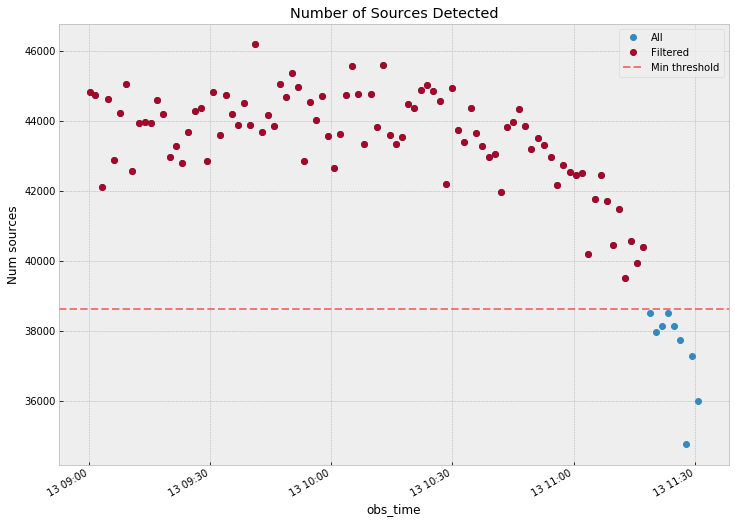

time: 5.71 s


In [12]:
plt.figure(figsize=(12, 9))
observation_sources.groupby('obs_time').count().picid.plot(marker='o', ls='', label='All')
observation_sources.groupby('obs_time').filter(
    lambda grp: grp.count().picid >= min_sources
).groupby('obs_time').count().file.plot(marker='o', ls='', label='Filtered')
plt.axhline(min_sources, c='r', alpha=0.5, ls='--', label='Min threshold')

plt.ylabel('Num sources')
plt.title('Number of Sources Detected')
plt.legend()

In [13]:
# Filter out the frames where the number of source detections is outside the std
observation_sources = observation_sources.groupby('obs_time').filter(lambda grp: grp.count()['file'] >= min_sources)

time: 3.79 s


In [14]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 91 Sources: 77724
time: 491 ms


#### Filter sources by number of frames

Now that we have removed frames where there were a low number of detections (presumably from clouds) we now want to remove sources that don't appear in most of the frames.

In [15]:
frame_count = observation_sources.groupby('picid').count().file
min_frame_count = int(frame_count.max() * .9)

print(f'Total frames: {frame_count.max()} Min cutout: {min_frame_count}')

Total frames: 91 Min cutout: 81
time: 1.27 s


In [ ]:
frame_count

Text(0.5, 1.0, 'Total number of frames')

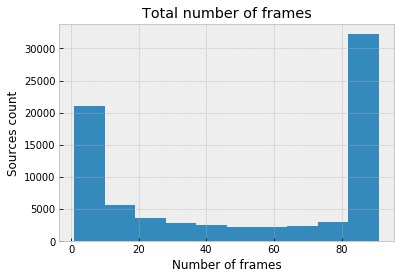

time: 237 ms


In [16]:
# Show a sample of the source count
frame_count.hist()
plt.xlabel('Number of frames')
plt.ylabel('Sources count')
plt.title('Total number of frames')

In [17]:
# Filter out the sources where the number of frames is less than min_frame_count
observation_sources = observation_sources.groupby('picid').filter(lambda grp: grp.count()['file'] >= min_frame_count)

time: 1min 26s


In [18]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 91 Sources: 32617
time: 308 ms


#### Filter frames by manual time-clipping

For now we are going to simply manually remove the frames after a certain time that was visually identified with cloud cover.

In [ ]:
observation_sources = observation_sources.loc[observation_sources.index.levels[1] < '2018-08-22 07:10:00']

#### Filter frames by Sigma-clip

We can sigma clip the frames based on the mean background value, removing any frame that deviate wildly from the rest of the sequence.

In [ ]:
back_mean, back_median, back_std = sigma_clipped_stats(image_group.background.mean())

observation_sources = observation_sources.groupby('obs_time').filter(lambda grp: np.abs(grp['background'].mean() - back_mean) <= 3 * back_std )

num_frames = len(observation_sources.index.unique())

In [ ]:
num_frames = len(observation_sources.index.levels[1].unique())
num_sources = len(observation_sources.index.levels[0].unique())
print(f"Frames: {num_frames} Sources: {num_sources}")

In [ ]:
plt.figure(figsize=(6, 4.5))
plt.plot(observation_sources.groupby('obs_time').background.mean().values, label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

#### Source filtering

`sextractor` does basic thresholding and source detection per frame but here we filter sources based off the entire image sequence. The simplest filter is to get all the images with a certain SNR limit (default 10). A filter for source extractor flags can also be used.

> Note: There has been a manual selection of images (see above) for overall data quality. Some kind of image quality check (e.g. drifting zeropoint) could help automate this

In [19]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 91 Sources: 32617
time: 305 ms


#### sextractor flags filter

Filter out anything with [SE flags](http://matilda.physics.ucdavis.edu/working/website/SEflags.html) of 4 or more. Note that this is leaving in some blended sources 

In [20]:
observation_sources = observation_sources.groupby('picid').filter(lambda grp: all(grp['flags'] < 4))

time: 17.2 s


In [21]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 91 Sources: 32495
time: 323 ms


##### SNR Filter

The SNR comes directly from `sextractor` in the form of `FLUX_AUTO / FLUXERR_AUTO`.

In [22]:
snr_limit = 10

high_snr = lambda grp: (grp['flux_best'] / grp['fluxerr_best']).mean() > snr_limit

observation_sources = observation_sources.groupby('picid').filter(high_snr)

time: 19.5 s


In [23]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 91 Sources: 16458
time: 146 ms


#### FWHM Filter

We also want to get rid of the stars where `sextractor` reports a large FWHM. This could be refined but for now we do a simple cut.

In [24]:
fwhm_limit = 5

low_fwhm = lambda grp: (grp['fwhm_image']).mean() <= fwhm_limit

observation_sources = observation_sources.groupby('picid').filter(low_fwhm)

time: 6.71 s


In [25]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 91 Sources: 10614
time: 91.9 ms


#### Output filtered source detections

We save this filtered file to be used for subsequent processing.

In [26]:
filtered_filename = os.path.join(base_dir, f'point-sources-filtered.csv.bz2')

time: 599 µs


In [27]:
observation_sources.to_csv(filtered_filename, compression='bz2')

time: 59.7 s


In [28]:
ls -lh $filtered_filename

-rw-r--r-- 1 wtylergee wtylergee 68M Dec 19 03:46 /var/panoptes/images/fields/PAN001/Hd189733/ee04d1/20180913T085704/point-sources-filtered.csv.bz2
time: 165 ms
